# 201805093 ZAHRAA ALTEKREETI

In [8]:
import re
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from nltk.corpus import stopwords
import nltk
from zemberek.morphology import TurkishMorphology
from zemberek.tokenization import TurkishTokenizer
from fuzzywuzzy import process
from collections import Counter
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load and process all sheets
file_path = "hate_speech.xlsx"  # Update with your file path
all_sheets = pd.read_excel(file_path, sheet_name=None, engine="openpyxl", header=None)

# Define important columns
important_columns = [
    "tweet", "etiket", "alt etiket", 
    "favorited", "retweeted", "is retweet", "user - afollowers", "time"
]
final_column_order = ["ID"] + important_columns + ["Keyword"]

def deduplicate_columns(columns):
    """Deduplicate column names by appending .1, .2, etc., for duplicates."""
    seen = {}
    unique_columns = []
    for col in columns:
        if col not in seen:
            seen[col] = 0
            unique_columns.append(col)
        else:
            seen[col] += 1
            unique_columns.append(f"{col}.{seen[col]}")
    return unique_columns

# Merge all sheets
merged_data = []
current_id = 1  # Start ID counter

for sheet_name, data in all_sheets.items():
    if sheet_name.lower() == "toplam":  # Skip "TOPLAM" sheet
        continue

    try:
        # Use the second row as headers
        data.columns = data.iloc[1]
        data = data.drop(index=[0, 1]).reset_index(drop=True)  # Drop metadata rows
    except IndexError:
        print(f"Sheet {sheet_name} is empty or malformed. Skipping.")
        continue

    # Deduplicate and normalize column names
    data.columns = deduplicate_columns(data.columns)
    data.columns = data.columns.str.lower().str.strip()

    # Ensure all column names are strings
    data.columns = data.columns.astype(str)
    
    # Extract first "etiket" and "alt etiket"
    if "etiket" in data.columns:
        data["etiket"] = data[[col for col in data.columns if col.startswith("etiket")]].iloc[:, 0]
        data = data.drop(columns=[col for col in data.columns if col.startswith("etiket") and col != "etiket"])
    if "alt etiket" in data.columns:
        data["alt etiket"] = data[[col for col in data.columns if col.startswith("alt etiket")]].iloc[:, 0]
        data = data.drop(columns=[col for col in data.columns if col.startswith("alt etiket") and col != "alt etiket"])


    # Keep only important columns
    available_columns = [col for col in important_columns if col in data.columns]
    filtered_data = data[available_columns].copy()

    # Add 'Keyword' column based on sheet name
    filtered_data["Keyword"] = sheet_name

    # Add unique IDs
    filtered_data.insert(0, "ID", range(current_id, current_id + len(filtered_data)))
    current_id += len(filtered_data)

    # Ensure all final columns exist
    for col in final_column_order:
        if col not in filtered_data.columns:
            filtered_data[col] = pd.NA
    filtered_data = filtered_data[final_column_order]

    merged_data.append(filtered_data)

# Combine all sheets into one DataFrame
try:
    final_dataset = pd.concat(merged_data, ignore_index=True)
    print("Merged dataset created successfully.")
except Exception as e:
    print(f"Error during concatenation: {e}")

# Save the combined dataset
if 'final_dataset' in locals() and not final_dataset.empty:
    final_dataset.to_excel("final_hate_speech.xlsx", index=False)
    print("Merged dataset saved to 'final_hate_speech.xlsx'.")
else:
    print("Final dataset is empty or not created.")

Merged dataset created successfully.
Merged dataset saved to 'final_hate_speech.xlsx'.


In [3]:
# Load Turkish stopwords and extend with custom ones
turkish_stopwords = set(stopwords.words('turkish'))
custom_stopwords = {"bir", "ve", "da", "de", "ile", "bu", "şu", "o", "ne"}
turkish_stopwords.update(custom_stopwords)

# Initialize Zemberek for lemmatization and tokenization
morphology = TurkishMorphology.create_with_defaults()
tokenizer = TurkishTokenizer.DEFAULT

# Function to remove Turkish stopwords
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word not in turkish_stopwords)

# Enhanced Lemmatization Function
def enhanced_lemmatize_turkish(text):
    words = text.split()
    lemmatized_words = []
    for word in words:
        analysis = morphology.analyze(word)
        if analysis.analysis_results:
            lemma = analysis.analysis_results[0].item.lemma
            lemmatized_words.append(lemma)
        else:
            # Preserve named entities and proper nouns
            if re.match(r'^[A-ZÇĞİÖŞÜ][a-zçğıöşü]+$', word):
                lemmatized_words.append(word)
            else:
                lemmatized_words.append(word)
    return ' '.join(lemmatized_words)
# Enhanced Cleaning Function
def clean_turkish_text(text):
    if pd.isnull(text):  # Handle NaN values
        return ""
    
# Enhanced Cleaning Function
def clean_turkish_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    slang_dict = {
        "yaa": "ya",
        "bişey": "bir şey",
        "keşke": "dilerim"
    }
    for slang, full_form in slang_dict.items():
        text = text.replace(slang, full_form)
    text = re.sub(r'[^a-zçğıöşü\s!]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Grammar and semantic fixes
def refine_output(text):
    proper_nouns = ['Türkiye', 'Suriye', 'Afgan', 'Pakistan', 'Ankara']
    for noun in proper_nouns:
        text = re.sub(rf'\b{noun.lower()}\b', noun, text)
    
    error_corrections = {
        "bilemek": "bilmek",
        "dilmek": "demek",
        "yaziyonuz": "yazıyorsunuz",
        "gelincede": "geldiğinde"
    }
    for error, correction in error_corrections.items():
        text = text.replace(error, correction)
    
    return re.sub(r'\s+', ' ', text).strip()

# Post-processing for malformed tokens
def fix_malformed_tokens(text):
    text = re.sub(r'\bbirr\b', 'bir', text)
    text = re.sub(r'\bbirrkaç\b', 'birkaç', text)
    return text

# Complete Preprocessing Pipeline
def preprocess_turkish(text):
    text = clean_turkish_text(text)        # Clean the text
    text = remove_stopwords(text)          # Remove Turkish stopwords
    text = enhanced_lemmatize_turkish(text)  # Enhanced lemmatization
    text = refine_output(text)             # Grammar and semantic fixes
    text = fix_malformed_tokens(text)      # Fix malformed tokens
    return text
    
# Load your data (replace the file path accordingly)
data = pd.read_excel('final_hate_speech.xlsx')

# Apply preprocessing to the 'tweet' column
data['tweet_cleaned'] = data['tweet'].apply(preprocess_turkish)

2024-12-22 13:23:02,453 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 5.878251552581787



In [4]:
data[['tweet', 'tweet_cleaned']]

,tweet,tweet_cleaned
0,ya orospu cocuklari hepiniz niye ayni anda yaz...,orospu cocuklari hep ayni an yazıyorsunuz tam ...
1,Ciddiye alan tüm dünyanın beynini sileyim.. \n...,ciddi almak dünya beyin silmek iş güç boş günd...
2,Kayıtlı İstihdama geçiş programına göre (?)\nŞ...,kayıt istihdam geçişmek program göre şimdilik ...
3,Hastaneye git Suriyeli. PTT ye git Suriyeli. P...,hastane gitmek Suriye Ptt yemek gitmek Suriye ...
4,Cölesi bitmiş suriyeli gibiyim bugün,cölesi bitmek Suriye gibi bugün
...,...,...
10219,Müslüman bir ülkeden hristiyan bir ülkeye gidi...,müslüman ülke hristiyan ülke gitmek ora Yaşam ...
10220,Kadının dini dili ırkı mı olur ya? Bu gün bari...,kadı dinî dil ırk olur gün bari faşist yapmak ...
10221,Mor renk eskiden istridyeden yapılabildiği iç...,mor renk eskiden istridyeden yapmak pahalı yüz...
10222,Taktığı haç'a takıladım da(neticede hristiyan ...,takmak haç takıladım daneticede hristiyan olma...


In [4]:
# Map labels
data['etiket'] = data['etiket'].map({"hiçbiri": 0, "nefret": 1, "saldırgan": 2})

# Define features and target
X = data['tweet_cleaned']
y = data['etiket']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Initialize vectorizers
vectorizers = {
    "CountVectorizer (unigram)": CountVectorizer(ngram_range=(1, 1)),
    "CountVectorizer (bigram)": CountVectorizer(ngram_range=(1, 2)),
    "TfidfVectorizer (unigram)": TfidfVectorizer(ngram_range=(1, 1)),
    "TfidfVectorizer (bigram)": TfidfVectorizer(ngram_range=(1, 2)),
}

# Initialize resampling methods
resampling_methods = {
    "Original": None,
    "Oversampling": RandomOverSampler(random_state=42),
    "Undersampling": RandomUnderSampler(random_state=42),
    "Combined": SMOTEENN(random_state=42),
}

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "ANN": MLPClassifier(random_state=42, max_iter=300),
}

# Initialize results storage
results = {}

In [10]:
X_resampled = X_resampled.astype(np.float32)
y_resampled = y_resampled.astype(np.float32)
X_test_vec = X_test_vec.astype(np.float32)

# Evaluate models
for vec_name, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    for res_name, resampler in resampling_methods.items():
        if resampler:
            X_resampled, y_resampled = resampler.fit_resample(X_train_vec, y_train)
        else:
            X_resampled, y_resampled = X_train_vec, y_train
        X_resampled = X_resampled.toarray().astype(np.float32) if hasattr(X_resampled, "toarray") else X_resampled.astype(np.float32)
        y_resampled = y_resampled.astype(np.float32)
        
        X_test_vec = X_test_vec.toarray().astype(np.float32) if hasattr(X_test_vec, "toarray") else X_test_vec.astype(np.float32)

        for model_name, model in models.items():
            print(f"Evaluating {model_name} with {vec_name} and {res_name}...")
            model.fit(X_resampled, y_resampled)
            y_pred = model.predict(X_test_vec)

            # Performance metrics
            report = classification_report(y_test, y_pred, output_dict=True)
            cm = confusion_matrix(y_test, y_pred)

            # Save results
            key = f"{model_name} | {vec_name} | {res_name}"
            results[key] = {
                "classification_report": report,
                "confusion_matrix": cm,
            }

            # Print metrics
            print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred))

Evaluating Random Forest with CountVectorizer (unigram) and Original...
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91      1527
           1       0.87      0.47      0.61       490
           2       1.00      0.11      0.19        28

    accuracy                           0.85      2045
   macro avg       0.91      0.52      0.57      2045
weighted avg       0.85      0.85      0.83      2045

Evaluating XGBoost with CountVectorizer (unigram) and Original...


C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.91      1527
           1       0.86      0.50      0.63       490
           2       0.67      0.36      0.47        28

    accuracy                           0.86      2045
   macro avg       0.79      0.61      0.67      2045
weighted avg       0.85      0.86      0.84      2045

Evaluating LightGBM with CountVectorizer (unigram) and Original...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3795
[LightGBM] [Info] Number of data points in the train set: 8179, number of used features: 1182
[LightGBM] [Info] Start training from score -0.277827
[LightGBM] [Info] Start training from score -1.488549
[LightGBM] [Info] Start training from score -4.082071
Ligh

C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:26:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      1527
           1       0.67      0.62      0.64       490
           2       0.37      0.50      0.42        28

    accuracy                           0.83      2045
   macro avg       0.64      0.67      0.65      2045
weighted avg       0.83      0.83      0.83      2045

Evaluating LightGBM with CountVectorizer (unigram) and Oversampling...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6280
[LightGBM] [Info] Number of data points in the train set: 18585, number of used features: 2247
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM Classification Report:
               precision    rec

C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.54      0.67      1527
           1       0.37      0.62      0.47       490
           2       0.07      0.75      0.13        28

    accuracy                           0.56      2045
   macro avg       0.44      0.64      0.42      2045
weighted avg       0.75      0.56      0.61      2045

Evaluating LightGBM with CountVectorizer (unigram) and Undersampling...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 414, number of used features: 36
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[Li

C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.06      0.12      1527
           1       0.30      0.92      0.46       490
           2       0.03      0.43      0.05        28

    accuracy                           0.27      2045
   macro avg       0.43      0.47      0.21      2045
weighted avg       0.79      0.27      0.20      2045

Evaluating LightGBM with CountVectorizer (unigram) and Combined...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 9626, number of used features: 320
[LightGBM] [Info] Start training from score -4.244969
[LightGBM] [Info] Start training from score -0.967825
[LightGBM] [Info] Start training from score -0.501279
Light

C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packag

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      1527
           1       0.90      0.41      0.56       490
           2       0.00      0.00      0.00        28

    accuracy                           0.84      2045
   macro avg       0.58      0.47      0.49      2045
weighted avg       0.84      0.84      0.81      2045

Evaluating XGBoost with CountVectorizer (bigram) and Original...


C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:11:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      1527
           1       0.86      0.50      0.63       490
           2       0.67      0.36      0.47        28

    accuracy                           0.86      2045
   macro avg       0.79      0.61      0.67      2045
weighted avg       0.86      0.86      0.84      2045

Evaluating LightGBM with CountVectorizer (bigram) and Original...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 8179, number of used features: 1298
[LightGBM] [Info] Start training from score -0.277827
[LightGBM] [Info] Start training from score -1.488549
[LightGBM] [Info] Start training from score -4.082071
Light

C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:03:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1527
           1       0.67      0.64      0.66       490
           2       0.39      0.50      0.44        28

    accuracy                           0.83      2045
   macro avg       0.65      0.68      0.66      2045
weighted avg       0.83      0.83      0.83      2045

Evaluating LightGBM with CountVectorizer (bigram) and Oversampling...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11643
[LightGBM] [Info] Number of data points in the train set: 18585, number of used features: 4846
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.57      0.69      1527
           1       0.39      0.63      0.48       490
           2       0.08      0.79      0.15        28

    accuracy                           0.59      2045
   macro avg       0.45      0.66      0.44      2045
weighted avg       0.76      0.59      0.64      2045

Evaluating LightGBM with CountVectorizer (bigram) and Undersampling...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 414, number of used features: 36
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[Lig

C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.02      0.04      1527
           1       0.30      0.91      0.45       490
           2       0.02      0.36      0.04        28

    accuracy                           0.24      2045
   macro avg       0.40      0.43      0.17      2045
weighted avg       0.73      0.24      0.14      2045

Evaluating LightGBM with CountVectorizer (bigram) and Combined...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 9297, number of used features: 336
[LightGBM] [Info] Start training from score -5.308806
[LightGBM] [Info] Start training from score -1.026719
[LightGBM] [Info] Start training from score -0.451186
[Light

C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packag

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91      1527
           1       0.87      0.43      0.58       490
           2       0.00      0.00      0.00        28

    accuracy                           0.84      2045
   macro avg       0.57      0.48      0.50      2045
weighted avg       0.84      0.84      0.82      2045

Evaluating XGBoost with TfidfVectorizer (unigram) and Original...


C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:29:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      1527
           1       0.87      0.50      0.63       490
           2       0.55      0.21      0.31        28

    accuracy                           0.86      2045
   macro avg       0.76      0.57      0.62      2045
weighted avg       0.86      0.86      0.84      2045

Evaluating LightGBM with TfidfVectorizer (unigram) and Original...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30524
[LightGBM] [Info] Number of data points in the train set: 8179, number of used features: 1182
[LightGBM] [Info] Start training from score -0.277827
[LightGBM] [Info] Start training from score -1.488549
[LightGBM] [Info] Start training from score -4.082071
Lig

C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:35:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      1527
           1       0.64      0.65      0.64       490
           2       0.32      0.36      0.34        28

    accuracy                           0.82      2045
   macro avg       0.62      0.63      0.62      2045
weighted avg       0.82      0.82      0.82      2045

Evaluating LightGBM with TfidfVectorizer (unigram) and Oversampling...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44669
[LightGBM] [Info] Number of data points in the train set: 18585, number of used features: 2247
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.09861

C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:40:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.56      0.68      1527
           1       0.38      0.61      0.47       490
           2       0.06      0.64      0.12        28

    accuracy                           0.57      2045
   macro avg       0.44      0.60      0.42      2045
weighted avg       0.74      0.57      0.62      2045

Evaluating LightGBM with TfidfVectorizer (unigram) and Undersampling...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 414, number of used features: 36
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[Li

C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packag

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.04      0.08      1527
           1       0.25      0.99      0.39       490
           2       0.00      0.00      0.00        28

    accuracy                           0.27      2045
   macro avg       0.40      0.34      0.16      2045
weighted avg       0.77      0.27      0.15      2045

Evaluating XGBoost with TfidfVectorizer (unigram) and Combined...


C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.02      0.04      1527
           1       0.25      0.99      0.40       490
           2       0.16      0.36      0.22        28

    accuracy                           0.26      2045
   macro avg       0.47      0.46      0.22      2045
weighted avg       0.81      0.26      0.13      2045

Evaluating LightGBM with TfidfVectorizer (unigram) and Combined...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82805
[LightGBM] [Info] Number of data points in the train set: 12378, number of used features: 1846
[LightGBM] [Info] Start training from score -4.705177
[LightGBM] [Info] Start training from score -0.712397
[LightGBM] [Info] Start training from score -0.692178
LightGBM Classification Report:
               precision    recall

C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abood\anaconda3\Lib\site-packag

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91      1527
           1       0.89      0.43      0.58       490
           2       0.00      0.00      0.00        28

    accuracy                           0.84      2045
   macro avg       0.58      0.47      0.50      2045
weighted avg       0.84      0.84      0.82      2045

Evaluating XGBoost with TfidfVectorizer (bigram) and Original...


C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.91      1527
           1       0.82      0.53      0.65       490
           2       0.59      0.36      0.44        28

    accuracy                           0.86      2045
   macro avg       0.76      0.62      0.67      2045
weighted avg       0.85      0.86      0.84      2045

Evaluating LightGBM with TfidfVectorizer (bigram) and Original...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31926
[LightGBM] [Info] Number of data points in the train set: 8179, number of used features: 1298
[LightGBM] [Info] Start training from score -0.277827
[LightGBM] [Info] Start training from score -1.488549
[LightGBM] [Info] Start training from score -4.082071
Ligh

C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87      1527
           1       0.60      0.68      0.64       490
           2       0.35      0.43      0.39        28

    accuracy                           0.81      2045
   macro avg       0.62      0.65      0.63      2045
weighted avg       0.82      0.81      0.81      2045

Evaluating LightGBM with TfidfVectorizer (bigram) and Oversampling...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 53511
[LightGBM] [Info] Number of data points in the train set: 18585, number of used features: 4846
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.54      0.66      1527
           1       0.37      0.62      0.46       490
           2       0.07      0.71      0.13        28

    accuracy                           0.56      2045
   macro avg       0.44      0.62      0.42      2045
weighted avg       0.74      0.56      0.61      2045

Evaluating LightGBM with TfidfVectorizer (bigram) and Undersampling...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 414, number of used features: 36
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[Lig

C:\Users\abood\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:15:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.09      0.17      1527
           1       0.26      0.98      0.42       490
           2       0.12      0.39      0.19        28

    accuracy                           0.31      2045
   macro avg       0.45      0.49      0.26      2045
weighted avg       0.78      0.31      0.23      2045

Evaluating LightGBM with TfidfVectorizer (bigram) and Combined...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158492
[LightGBM] [Info] Number of data points in the train set: 12205, number of used features: 4598
[LightGBM] [Info] Start training from score -4.467959
[LightGBM] [Info] Start training from score -0.731991
[LightGBM] [Info] Start training from score -0.678103
Li

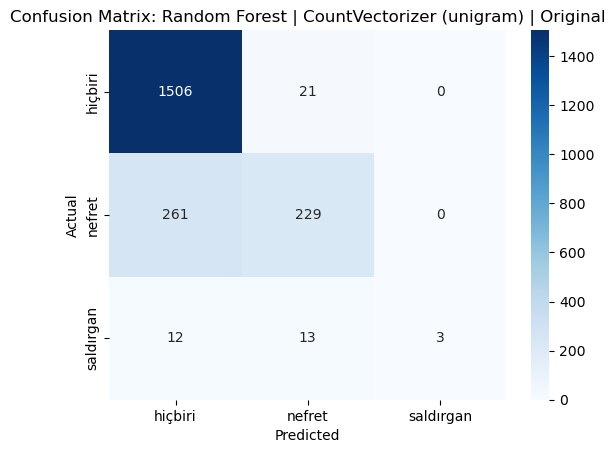

All evaluations completed and results saved.


In [11]:
# Save results
with open('classification_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Visualize an example confusion matrix
example_key = list(results.keys())[0]
cm_example = results[example_key]["confusion_matrix"]
sns.heatmap(cm_example, annot=True, fmt="d", cmap="Blues", xticklabels=["hiçbiri", "nefret", "saldırgan"], yticklabels=["hiçbiri", "nefret", "saldırgan"])
plt.title(f"Confusion Matrix: {example_key}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("All evaluations completed and results saved.")

In [16]:
# Group by model and calculate average metrics
grouped_results = summary_df.groupby("Model").agg({
    "Accuracy": "mean",
    "Precision": "mean",
    "Recall": "mean",
    "F1-Score": "mean",
}).sort_values(by="Accuracy", ascending=False)

print(grouped_results)

               Accuracy  Precision    Recall  F1-Score
Model                                                 
Random Forest  0.635147   0.802096  0.635147  0.602461
XGBoost        0.629187   0.800679  0.629187  0.614065
ANN            0.613509   0.801168  0.613509  0.595809
LightGBM       0.606082   0.796729  0.606082  0.601026


In [19]:
from tabulate import tabulate
import time

# Display the table in chunks without requiring user input
chunk_size = 10
for i in range(0, len(summary_df), chunk_size):
    print(tabulate(summary_df.iloc[i:i+chunk_size], headers="keys", tablefmt="pretty"))
    print("\n--- Displaying next chunk in 2 seconds ---\n")
    time.sleep(2)  # Pause for 2 seconds before showing the next chunk

+----+---------------+---------------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------+
|    |     Model     |        Vectorizer         | Resampling Method |      Accuracy      |     Precision      |       Recall       |      F1-Score      | Rank |
+----+---------------+---------------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------+
| 34 |   LightGBM    | TfidfVectorizer (unigram) |     Original      | 0.8596577017114915 | 0.8556637315247136 | 0.8596577017114915 | 0.8467210489105925 |  1   |
| 33 |    XGBoost    | TfidfVectorizer (unigram) |     Original      | 0.8577017114914426 | 0.8562150057980004 | 0.8577017114914426 | 0.8408274669924349 |  2   |
| 17 |    XGBoost    | CountVectorizer (bigram)  |     Original      | 0.8572127139364303 | 0.8558784232246079 | 0.8572127139364303 | 0.8419381007184437 |  3   |
| 18 |   LightGBM    | Count

2024-12-22 20:44:19,655 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.

2024-12-22 20:44:19,661 - matplotlib.category - INFO
Msg: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



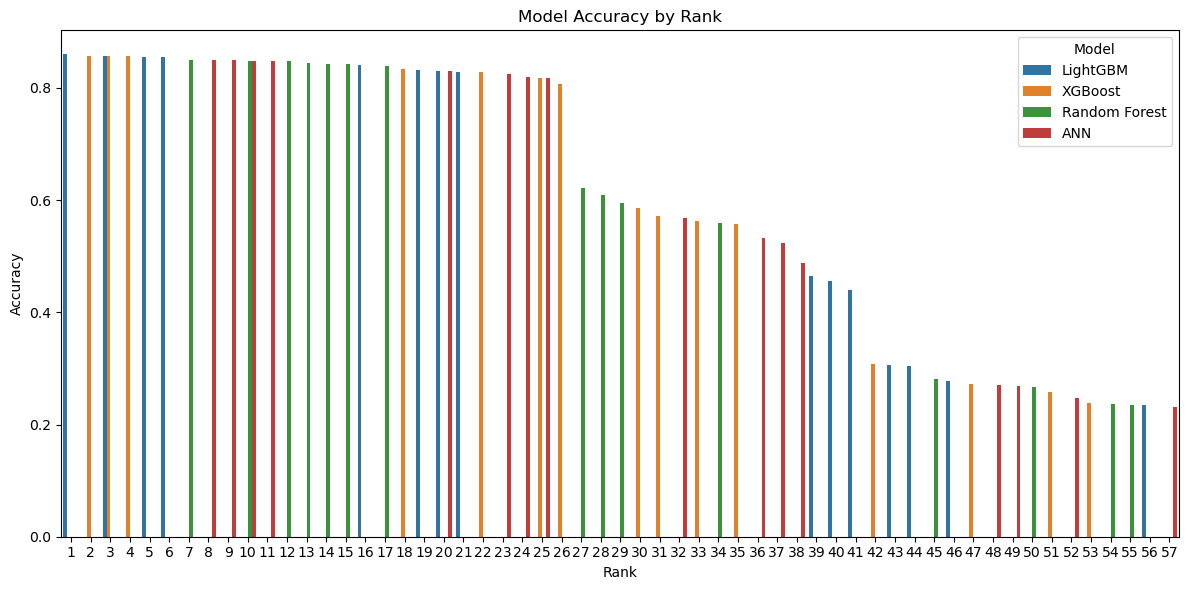

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x="Rank", y="Accuracy", hue="Model")
plt.title("Model Accuracy by Rank")
plt.xlabel("Rank")
plt.ylabel("Accuracy")
plt.legend(title="Model")
plt.tight_layout()
plt.show()